In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Questão 1a.

In [61]:
data = pd.read_csv('womens-clothing-e-commerce-reviews.csv')

In [62]:
data.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

In [63]:
data = data[['Review Text','Rating']]
data = data.dropna() # remocao de valores NaN
data.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5


In [64]:
data['Rating'].value_counts()

5    12540
4     4908
3     2823
2     1549
1      821
Name: Rating, dtype: int64

In [65]:
print('Quantidade de textos: {} - Quantidade de categorias: {}'.format(data.shape[0] ,len(data['Rating'].unique())))
print('Categorias: {}'.format(data['Rating'].unique()))

Quantidade de textos: 22641 - Quantidade de categorias: 5
Categorias: [4 5 3 2 1]


In [66]:
maxlen = 300 # Cuts off reviews after 300 words 
training_samples = 18111 # Trains on 18111 samples (80%)
test_samples = 2264 # Tests on 2264 samples (10%) 
validation_samples = 2264 # Validates on 2264 samples (10%)
max_words = 10000 # Considers only the top 10,000 words in the dataset

In [67]:
texts = data['Review Text'].values

In [68]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [69]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14847 unique tokens.


In [70]:
data_pad = pad_sequences(sequences, maxlen=maxlen)

In [71]:
labels = data['Rating'].values
print('Shape of data tensor:', data_pad.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (22641, 600)
Shape of label tensor: (22641,)


# Questão 1b.

# Splits the data into a training set and a validation set

In [72]:
indices = np.arange(data_pad.shape[0])
np.random.shuffle(indices)
data_pad = data_pad[indices]
labels = labels[indices]

In [73]:
x_train = data_pad[:training_samples]
y_train = labels[:training_samples]
x_test = data_pad[training_samples:training_samples + test_samples]
y_test = labels[training_samples:training_samples + test_samples]
x_val = data_pad[training_samples + test_samples: training_samples + test_samples + validation_samples]
y_val = labels[training_samples + test_samples: training_samples + test_samples + validation_samples]

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM

def create_lstm_model(embedding_dim, units):
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    model.add(LSTM(units=units))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5, activation='sigmoid'))
    
    return model

In [16]:
model_show = create_lstm_model(128, 128)
model_show.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 128)          1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 1,415,877
Trainable params: 1,415,877
Non-trainable params: 0
_________________________________________________________________


In [74]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

In [75]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [76]:
lrs = [0.001, 0.01, 0.1]
epochs = [10, 20, 50]

In [19]:
from keras.optimizers import RMSprop

In [20]:
embedding_dim, units = 128, 128

for lr in lrs:
    opt = RMSprop(lr=lr, rho=0.9, epsilon=None, decay=0.0)
    model = create_lstm_model(embedding_dim=embedding_dim, units=units)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
    
    history = model.fit(x_train, y_train,
    epochs=epochs[2],
    batch_size=256,
    validation_data=(x_val, y_val))
    histories.append(history)

In [33]:
histories

In [21]:
import matplotlib.pyplot as plt

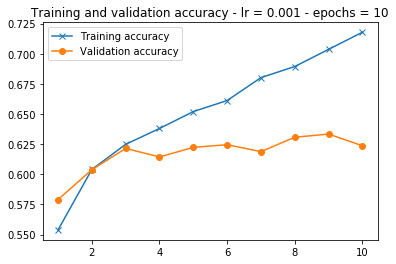

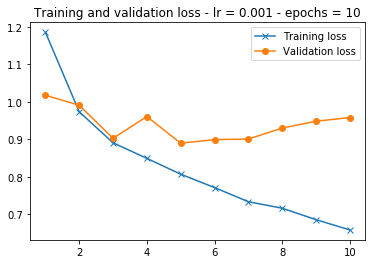

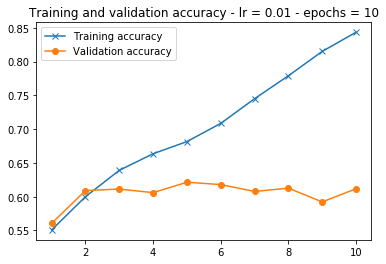

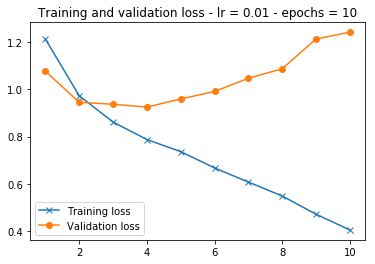

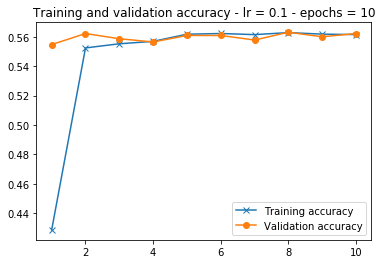

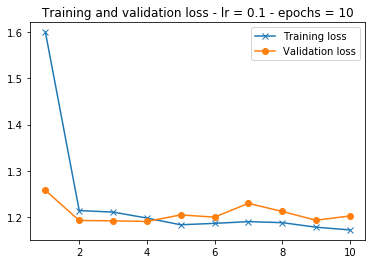

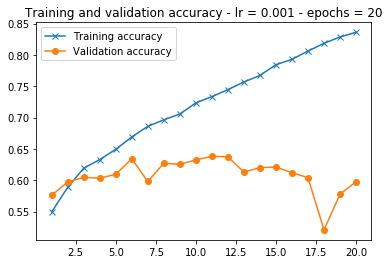

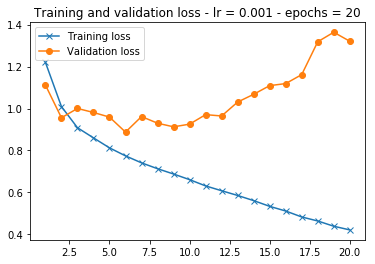

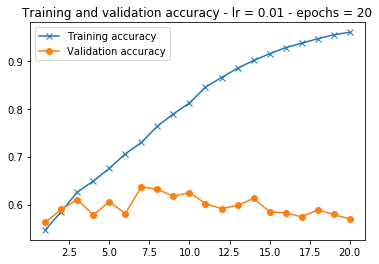

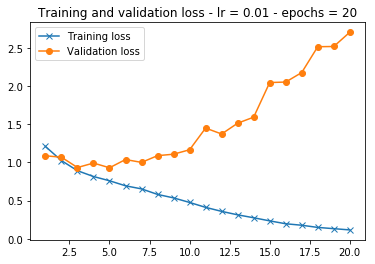

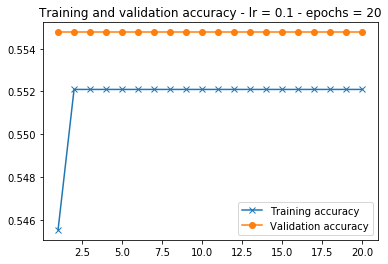

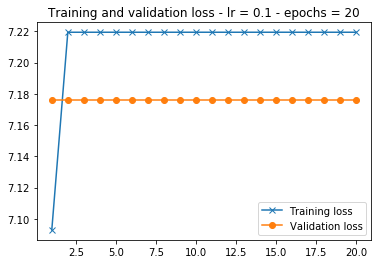

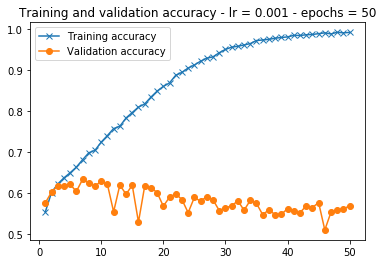

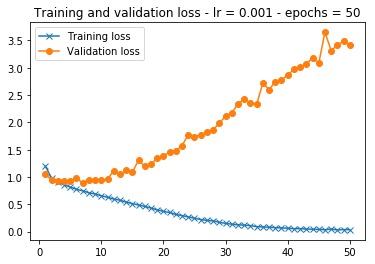

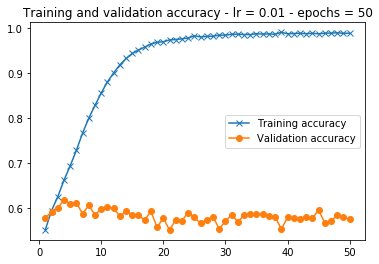

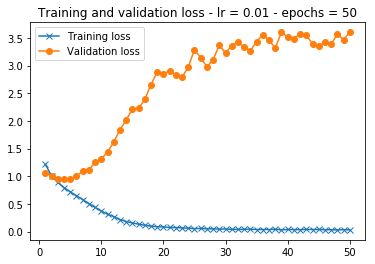

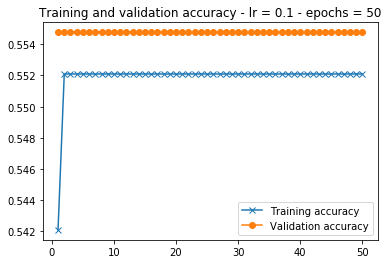

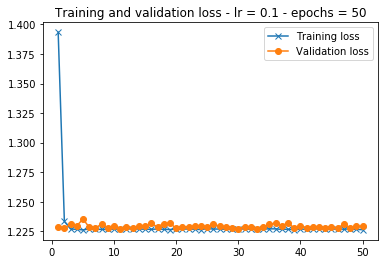

In [35]:
i = 0

for history in histories:
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label='Training accuracy', marker='x')
    plt.plot(epochs, val_acc, label='Validation accuracy', marker='o')
    plt.title('Training and validation accuracy - lr = {} - epochs = {}'.format(lrs[i % 3], len(acc)))
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='Training loss', marker='x')
    plt.plot(epochs, val_loss, label='Validation loss', marker='o')
    plt.title('Training and validation loss - lr = {} - epochs = {}'.format(lrs[i % 3], len(acc)))
    plt.legend()

    plt.show()
    i = i + 1

In [37]:
# lr=0.01, epochs=50 (best params)
opt = RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
final_model = create_lstm_model(embedding_dim=embedding_dim, units=units)
final_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

history = final_model.fit(x_train, y_train,
epochs=50,
batch_size=256,
validation_data=(x_val, y_val))

Train on 18111 samples, validate on 2264 samples
Epoch 1/50
18111/18111 [==============================] - 59s 3ms/step - loss: 1.1961 - acc: 0.5520 - val_loss: 1.0265 - val_acc: 0.5852
Epoch 2/50
18111/18111 [==============================] - 68s 4ms/step - loss: 0.9819 - acc: 0.5960 - val_loss: 0.9797 - val_acc: 0.5958
Epoch 3/50
18111/18111 [==============================] - 66s 4ms/step - loss: 0.8740 - acc: 0.6281 - val_loss: 0.9286 - val_acc: 0.6078
Epoch 4/50
18111/18111 [==============================] - 62s 3ms/step - loss: 0.7863 - acc: 0.6620 - val_loss: 1.0045 - val_acc: 0.5649
Epoch 5/50
18111/18111 [==============================] - 65s 4ms/step - loss: 0.7311 - acc: 0.6821 - val_loss: 0.9704 - val_acc: 0.6060
Epoch 6/50
18111/18111 [==============================] - 65s 4ms/step - loss: 0.6648 - acc: 0.7066 - val_loss: 0.9986 - val_acc: 0.6056
Epoch 7/50
18111/18111 [==============================] - 61s 3ms/step - loss: 0.6049 - acc: 0.7297 - val_loss: 1.0864 - val_acc:

# Questão 1c.

In [40]:
loss, acc = final_model.evaluate(x=x_test, y=y_test, batch_size=256, verbose=1)

2264/2264 [==============================] - 2s 1ms/step


In [42]:
print('Loss: {} - Accuracy: {} for test set'.format(loss, acc))

Loss: 3.4709626111883156 - Accuracy: 0.5702296805044788 for test set


# Questão 1d.

## 5 epochs

In [43]:
opt = RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)

final_model_5 = create_lstm_model(embedding_dim=embedding_dim, units=units)
final_model_5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

history = final_model_5.fit(x_train, y_train,
epochs=5,
batch_size=256,
validation_data=(x_val, y_val))

Train on 18111 samples, validate on 2264 samples
Epoch 1/5
18111/18111 [==============================] - 65s 4ms/step - loss: 1.1938 - acc: 0.5525 - val_loss: 1.1369 - val_acc: 0.5707
Epoch 2/5
18111/18111 [==============================] - 57s 3ms/step - loss: 0.9987 - acc: 0.5916 - val_loss: 0.9478 - val_acc: 0.5901
Epoch 3/5
18111/18111 [==============================] - 61s 3ms/step - loss: 0.8509 - acc: 0.6347 - val_loss: 0.9080 - val_acc: 0.6250
Epoch 4/5
18111/18111 [==============================] - 54s 3ms/step - loss: 0.7715 - acc: 0.6663 - val_loss: 0.9666 - val_acc: 0.6232
Epoch 5/5
18111/18111 [==============================] - 55s 3ms/step - loss: 0.6937 - acc: 0.7015 - val_loss: 1.0661 - val_acc: 0.5883


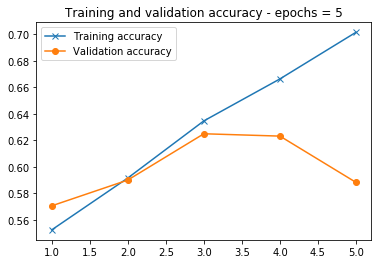

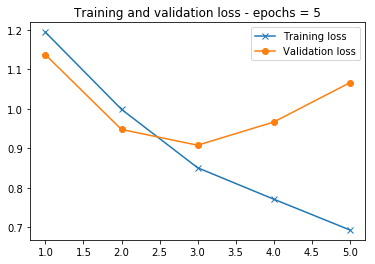

In [44]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training accuracy', marker='x')
plt.plot(epochs, val_acc, label='Validation accuracy', marker='o')
plt.title('Training and validation accuracy - epochs = {}'.format(len(acc)))
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training loss', marker='x')
plt.plot(epochs, val_loss, label='Validation loss', marker='o')
plt.title('Training and validation loss - epochs = {}'.format(len(acc)))
plt.legend()

plt.show()

In [45]:
loss, acc = final_model_5.evaluate(x=x_test, y=y_test, batch_size=256, verbose=1)
print('Loss: {} - Accuracy: {} for test set'.format(loss, acc))

2264/2264 [==============================] - 2s 967us/step
Loss: 1.0499616242129053 - Accuracy: 0.5909894001357547 for test set


## 12 epochs

In [49]:
opt = RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)

final_model_12 = create_lstm_model(embedding_dim=embedding_dim, units=units)
final_model_12.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

history = final_model_12.fit(x_train, y_train,
epochs=12,
batch_size=256,
validation_data=(x_val, y_val))

Train on 18111 samples, validate on 2264 samples
Epoch 1/12
18111/18111 [==============================] - 69s 4ms/step - loss: 1.2346 - acc: 0.5529 - val_loss: 1.0374 - val_acc: 0.5751
Epoch 2/12
18111/18111 [==============================] - 69s 4ms/step - loss: 0.9962 - acc: 0.5935 - val_loss: 1.0103 - val_acc: 0.5764
Epoch 3/12
18111/18111 [==============================] - 57s 3ms/step - loss: 0.8742 - acc: 0.6306 - val_loss: 0.9429 - val_acc: 0.6047
Epoch 4/12
18111/18111 [==============================] - 54s 3ms/step - loss: 0.7854 - acc: 0.6638 - val_loss: 0.9358 - val_acc: 0.6175
Epoch 5/12
18111/18111 [==============================] - 57s 3ms/step - loss: 0.7146 - acc: 0.6908 - val_loss: 1.0025 - val_acc: 0.6011
Epoch 6/12
18111/18111 [==============================] - 55s 3ms/step - loss: 0.6449 - acc: 0.7180 - val_loss: 1.0219 - val_acc: 0.5755
Epoch 7/12
18111/18111 [==============================] - 55s 3ms/step - loss: 0.5837 - acc: 0.7429 - val_loss: 1.0420 - val_acc:

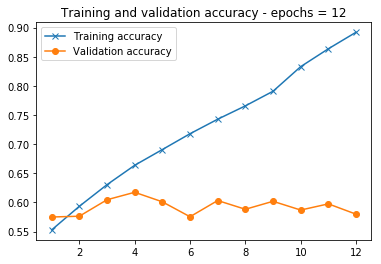

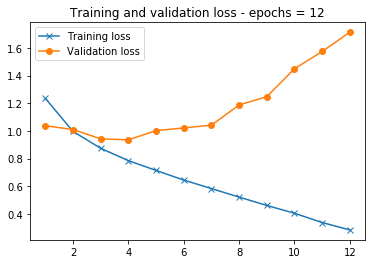

In [50]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training accuracy', marker='x')
plt.plot(epochs, val_acc, label='Validation accuracy', marker='o')
plt.title('Training and validation accuracy - epochs = {}'.format(len(acc)))
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training loss', marker='x')
plt.plot(epochs, val_loss, label='Validation loss', marker='o')
plt.title('Training and validation loss - epochs = {}'.format(len(acc)))
plt.legend()

plt.show()

In [54]:
loss, acc = final_model_12.evaluate(x=x_test, y=y_test, batch_size=256, verbose=1)
print('Loss: {} - Accuracy: {} for test set'.format(loss, acc))

2264/2264 [==============================] - 2s 988us/step
Loss: 1.7269035902124412 - Accuracy: 0.5896643090585095 for test set


## 50 epochs

In [55]:
loss, acc = final_model.evaluate(x=x_test, y=y_test, batch_size=256, verbose=1)
print('Loss: {} - Accuracy: {} for test set'.format(loss, acc))

2264/2264 [==============================] - 2s 966us/step
Loss: 3.4709626111883156 - Accuracy: 0.5702296805044788 for test set


# Questão 1e.

In [58]:
opt = RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
model_half = create_lstm_model(embedding_dim=embedding_dim, units=units // 2)
model_half.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

history = model_half.fit(x_train, y_train,
epochs=50,
batch_size=256,
validation_data=(x_val, y_val))

Train on 18111 samples, validate on 2264 samples
Epoch 1/50
18111/18111 [==============================] - 45s 2ms/step - loss: 1.1410 - acc: 0.5676 - val_loss: 1.0288 - val_acc: 0.5844
Epoch 2/50
18111/18111 [==============================] - 37s 2ms/step - loss: 0.9350 - acc: 0.6105 - val_loss: 0.9898 - val_acc: 0.6069
Epoch 3/50
18111/18111 [==============================] - 37s 2ms/step - loss: 0.7983 - acc: 0.6599 - val_loss: 0.8952 - val_acc: 0.6316
Epoch 4/50
18111/18111 [==============================] - 36s 2ms/step - loss: 0.7039 - acc: 0.7040 - val_loss: 0.9267 - val_acc: 0.6184
Epoch 5/50
18111/18111 [==============================] - 36s 2ms/step - loss: 0.6158 - acc: 0.7447 - val_loss: 1.0256 - val_acc: 0.6153
Epoch 6/50
18111/18111 [==============================] - 37s 2ms/step - loss: 0.5245 - acc: 0.7879 - val_loss: 1.1671 - val_acc: 0.6104
Epoch 7/50
18111/18111 [==============================] - 36s 2ms/step - loss: 0.4422 - acc: 0.8218 - val_loss: 1.2356 - val_acc:

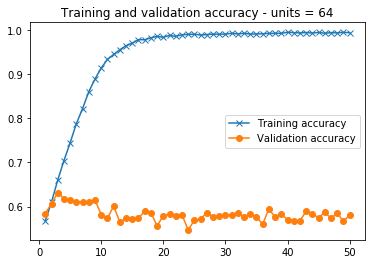

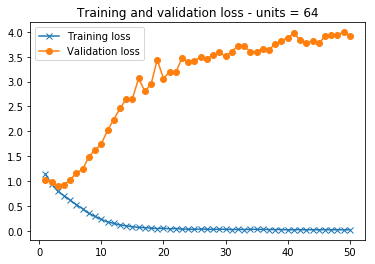

In [59]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training accuracy', marker='x')
plt.plot(epochs, val_acc, label='Validation accuracy', marker='o')
plt.title('Training and validation accuracy - units = {}'.format(units // 2))
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training loss', marker='x')
plt.plot(epochs, val_loss, label='Validation loss', marker='o')
plt.title('Training and validation loss - units = {}'.format(units // 2))
plt.legend()

plt.show()

In [62]:
loss, acc = model_half.evaluate(x=x_test, y=y_test, batch_size=256, verbose=1)
print('Loss: {} - Accuracy: {} for test set'.format(loss, acc))

2264/2264 [==============================] - 2s 692us/step
Loss: 3.8731434876000503 - Accuracy: 0.5812720856481222 for test set


In [61]:
opt = RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
model_double = create_lstm_model(embedding_dim=embedding_dim, units=units * 2)
model_double.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

history = model_double.fit(x_train, y_train,
epochs=50,
batch_size=256,
validation_data=(x_val, y_val))

Train on 18111 samples, validate on 2264 samples
Epoch 1/50
18111/18111 [==============================] - 137s 8ms/step - loss: 1.3384 - acc: 0.5455 - val_loss: 1.2282 - val_acc: 0.5601
Epoch 2/50
18111/18111 [==============================] - 129s 7ms/step - loss: 1.1475 - acc: 0.5560 - val_loss: 1.1213 - val_acc: 0.5667
Epoch 3/50
18111/18111 [==============================] - 128s 7ms/step - loss: 1.0704 - acc: 0.5823 - val_loss: 1.0291 - val_acc: 0.5813
Epoch 4/50
18111/18111 [==============================] - 128s 7ms/step - loss: 0.9763 - acc: 0.6016 - val_loss: 0.9656 - val_acc: 0.6042
Epoch 5/50
18111/18111 [==============================] - 128s 7ms/step - loss: 1.0608 - acc: 0.5823 - val_loss: 1.0093 - val_acc: 0.5897
Epoch 6/50
18111/18111 [==============================] - 140s 8ms/step - loss: 0.9190 - acc: 0.6153 - val_loss: 0.9269 - val_acc: 0.6095
Epoch 7/50
18111/18111 [==============================] - 135s 7ms/step - loss: 0.8384 - acc: 0.6397 - val_loss: 0.9690 - v

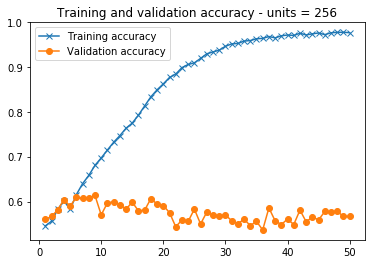

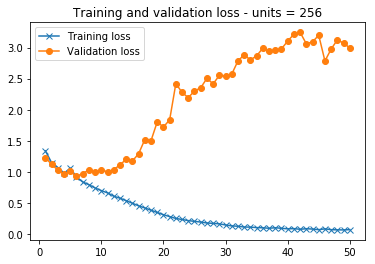

In [63]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training accuracy', marker='x')
plt.plot(epochs, val_acc, label='Validation accuracy', marker='o')
plt.title('Training and validation accuracy - units = {}'.format(units * 2))
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training loss', marker='x')
plt.plot(epochs, val_loss, label='Validation loss', marker='o')
plt.title('Training and validation loss - units = {}'.format(units * 2))
plt.legend()

plt.show()

In [65]:
# segundo caso demorou mais a convergir, porem apresentou menor loss
loss, acc = model_double.evaluate(x=x_test, y=y_test, batch_size=256, verbose=1)
print('Loss: {} - Accuracy: {} for test set'.format(loss, acc))

2264/2264 [==============================] - 5s 2ms/step
Loss: 2.961806189466281 - Accuracy: 0.5750883371164437 for test set


# Questão 1f.

## Maxlen = 600 (2x)

In [78]:
opt = RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
model = create_lstm_model(embedding_dim=embedding_dim, units=units)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train,
epochs=50,
batch_size=256,
validation_data=(x_val, y_val))

Train on 18111 samples, validate on 2264 samples
Epoch 1/50
18111/18111 [==============================] - 124s 7ms/step - loss: 1.1669 - acc: 0.5587 - val_loss: 1.0874 - val_acc: 0.5640
Epoch 2/50
18111/18111 [==============================] - 120s 7ms/step - loss: 1.0502 - acc: 0.5806 - val_loss: 1.0169 - val_acc: 0.5791
Epoch 3/50
18111/18111 [==============================] - 119s 7ms/step - loss: 0.9295 - acc: 0.6159 - val_loss: 0.9472 - val_acc: 0.6020
Epoch 4/50
18111/18111 [==============================] - 121s 7ms/step - loss: 0.8120 - acc: 0.6590 - val_loss: 0.8770 - val_acc: 0.6299
Epoch 5/50
18111/18111 [==============================] - 121s 7ms/step - loss: 0.7221 - acc: 0.6971 - val_loss: 0.9596 - val_acc: 0.6272
Epoch 6/50
18111/18111 [==============================] - 119s 7ms/step - loss: 0.6350 - acc: 0.7333 - val_loss: 0.9480 - val_acc: 0.6148
Epoch 7/50
18111/18111 [==============================] - 118s 7ms/step - loss: 0.5411 - acc: 0.7788 - val_loss: 1.0648 - v

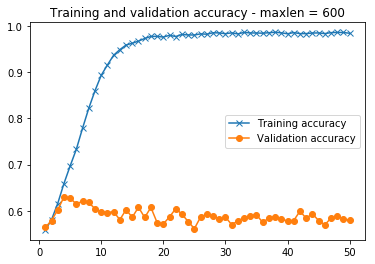

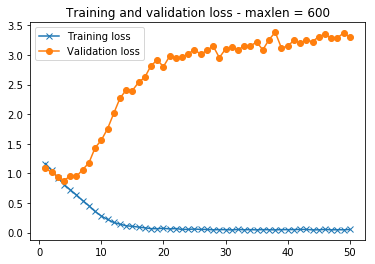

In [79]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training accuracy', marker='x')
plt.plot(epochs, val_acc, label='Validation accuracy', marker='o')
plt.title('Training and validation accuracy - maxlen = {}'.format(maxlen))
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training loss', marker='x')
plt.plot(epochs, val_loss, label='Validation loss', marker='o')
plt.title('Training and validation loss - maxlen = {}'.format(maxlen))
plt.legend()

plt.show()

In [80]:
loss, acc = model.evaluate(x=x_test, y=y_test, batch_size=256, verbose=1)
print('Loss: {} - Accuracy: {} for test set'.format(loss, acc))

2264/2264 [==============================] - 5s 2ms/step
Loss: 3.33554532249909 - Accuracy: 0.5870141357499382 for test set


## Maxlen = 150 (0.5x)

In [38]:
opt = RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
model = create_lstm_model(embedding_dim=embedding_dim, units=units)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train,
epochs=50,
batch_size=256,
validation_data=(x_val, y_val))

Train on 18111 samples, validate on 2264 samples
Epoch 1/50
18111/18111 [==============================] - 31s 2ms/step - loss: 1.2174 - acc: 0.5514 - val_loss: 1.1424 - val_acc: 0.5557
Epoch 2/50
18111/18111 [==============================] - 29s 2ms/step - loss: 0.9863 - acc: 0.6011 - val_loss: 1.0158 - val_acc: 0.5760
Epoch 3/50
18111/18111 [==============================] - 28s 2ms/step - loss: 0.8668 - acc: 0.6349 - val_loss: 0.8869 - val_acc: 0.6237
Epoch 4/50
18111/18111 [==============================] - 28s 2ms/step - loss: 0.7925 - acc: 0.6597 - val_loss: 0.9188 - val_acc: 0.6011
Epoch 5/50
18111/18111 [==============================] - 28s 2ms/step - loss: 0.7282 - acc: 0.6858 - val_loss: 0.9343 - val_acc: 0.6126
Epoch 6/50
18111/18111 [==============================] - 28s 2ms/step - loss: 0.6571 - acc: 0.7116 - val_loss: 0.9349 - val_acc: 0.6188
Epoch 7/50
18111/18111 [==============================] - 28s 2ms/step - loss: 0.5939 - acc: 0.7354 - val_loss: 1.0514 - val_acc:

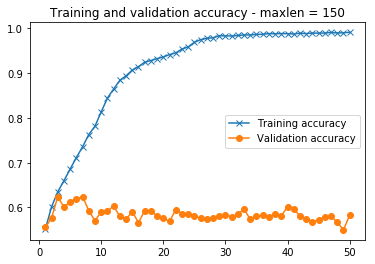

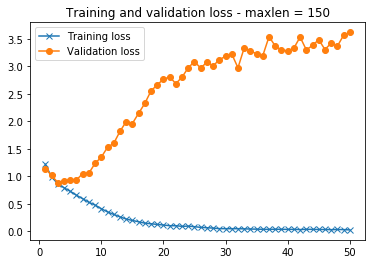

In [42]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training accuracy', marker='x')
plt.plot(epochs, val_acc, label='Validation accuracy', marker='o')
plt.title('Training and validation accuracy - maxlen = {}'.format(maxlen))
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training loss', marker='x')
plt.plot(epochs, val_loss, label='Validation loss', marker='o')
plt.title('Training and validation loss - maxlen = {}'.format(maxlen))
plt.legend()

plt.show()

In [43]:
loss, acc = model.evaluate(x=x_test, y=y_test, batch_size=256, verbose=1)
print('Loss: {} - Accuracy: {} for test set'.format(loss, acc))

2264/2264 [==============================] - 1s 527us/step
Loss: 3.67110210930922 - Accuracy: 0.576413426719369 for test set
